# Utilizando Transfer-learning para classificar imagens de pandas e ursos
  Esse projeto tem por objetivo realizar um transfer-learning de uma rede     neural já existente e uma boa perfomance em um dataset, para criar um novo modelo que consiga classificar entre pandas e ursos.

  O seguinte trabalho é um desafio de projeto do Bootcamp de Machine Learning da DIO em conjunto com a BairesDEV.

  ### Funcionamento
  Utilizaremos a rede VGG16 que é treinada com os datasets do ImageNet. Seguindo os passos do exemplo de transfer-learning, removeremos a última camada da rede e a substituiremos com uma nova camada, treinada já com o novo dataset e apta para classificar.

  ### Importação das bibliotecas
  Aqui há o uso de bibliotecas *os*, *random*, *numpy*, *keras* e *matplotlib*

In [ ]:
# Permite que os gráficos sejam visualizados diretamente no notebook
%matplotlib inline

import os

#caso esteja usando Theano com GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

### Carregando o Dataset para a utilização no transfer-learning
  Utilizando um código para extrair de uma URL da internet para uma pasta no repositório local ([Link aqui](https://github.com/MkDev21IA/banco-de-imagens/blob/main/codigo-para-baixar-imagens.py))

  Criei duas pastas, uma contendo 97 imagens de um panda (Ailuropoda melanoleuca) e a outra contendo 97 imagens de um urso polar (Ursus maritimus).

  Dessa forma, conseguimos carregamos essas pastas para o código.

In [ ]:
root = '/content/dataset'
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]

print(categories)

['/content/dataset/ursos', '/content/dataset/pandas']


In [ ]:
# Função para carregar imagem e retornar a imagem e também o vetor de input
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

Carregar todas as imagens de *root*

In [ ]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

# count the number of classes
num_classes = len(categories)

Embaralhar a ordem dos dados

In [ ]:
random.shuffle(data)

Criar separação treinamento / validação / teste (70%, 15%, 15%)

In [ ]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

Dados separados por rótulos (O resultado é 0 e 1 pois há somente 2 rótulos/grupos)

In [ ]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1]


Pré-processando os dados, certificando-se de que sejam float32 e normalizados entre 0 e 1.

In [ ]:
# normalizando os dados
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convertendo rótulos para vetores one-hot (codificação de dados)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(30, 2)


Um resumo do que se tem até o momento

In [ ]:
# resumo
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)

finished loading 194 images from 2 categories
train / validation / test split: 135, 29, 30
training data shape:  (135, 224, 224, 3)
training labels shape:  (135, 2)


Visualização de exemplos simples do dataset

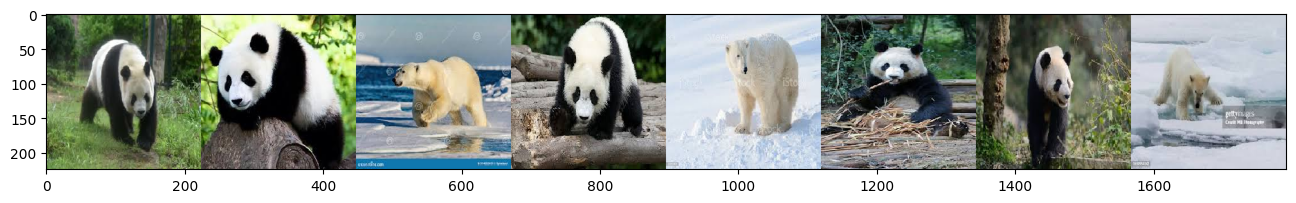

In [ ]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

### Começando com a rede já existente
  Iremos carregar o VGG16 do keras treinado com ImageNet e seus pesos salvos online. Carregamos e depois utilizamos o método summary()

In [ ]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 18s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

  Agora chega a fase de eliminar a última camada e a substituímos por uma nova para nosso dataset que contém 2 neurônios.
  Nesse caso, criamos uma cópia do VGG e ignoramos a última camada, ao invés de mexer diretamente com o objeto VGG.

In [ ]:
# Faz uma referência a camada de entrada do VGG
inp = vgg.input

# Faz uma nova camada softmax com 2 neurônios
new_classification_layer = Dense(num_classes, activation='softmax')

# Conecta nossa nova camada a penúltima do VGG e faz uma referência a isso
out = new_classification_layer(vgg.layers[-2].output)

# Cria uma nova rede entre inp e out
model_new = Model(inp, out)

Agora é o momento de re-treinar a rede deixando todas menos a última camada fixas,

In [ ]:
# Faz com que somente a última camada possa ser modificada
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# Garante que a última camada é treinável
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 8,194 (32.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

Treinando o novo modelo

In [ ]:
history2 = model_new.fit(x_train, y_train,
                         batch_size=128,
                         epochs=10,
                         validation_data=(x_val, y_val))

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 124s 27s/step - accuracy: 0.4700 - loss: 0.7763 - val_accuracy: 0.6207 - val_loss: 0.6383
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 133s 25s/step - accuracy: 0.5176 - loss: 0.7429 - val_accuracy: 0.3793 - val_loss: 1.4459
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 137s 23s/step - accuracy: 0.4975 - loss: 1.1463 - val_accuracy: 0.3793 - val_loss: 0.8873
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 144s 25s/step - accuracy: 0.5199 - loss: 0.7189 - val_accuracy: 0.6207 - val_loss: 0.6537
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 110s 25s/step - accuracy: 0.5126 - loss: 0.8251 - val_accuracy: 0.6207 - val_loss: 0.7697
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 115s 25s/step - accuracy: 0.4973 - loss: 1.0097 - val_accuracy: 0.7241 - val_loss: 0.5128
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 112s 25s/step - accuracy: 0.5953 - loss: 0.6028 - val_accuracy: 0.6897 - val_loss: 0.5826
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 133s 49s/step - accuracy: 0.6960 - loss: 0.5221 - val_accuracy: 0.3793 - val_loss:

  A acurácia nesse caso deu em torno de 64% que provavelmente seria uma porcentagem maior do que caso tivéssemos criado nossa própria rede.

  Segue abaixo os gráficos de perda e acurácia do treinamento.

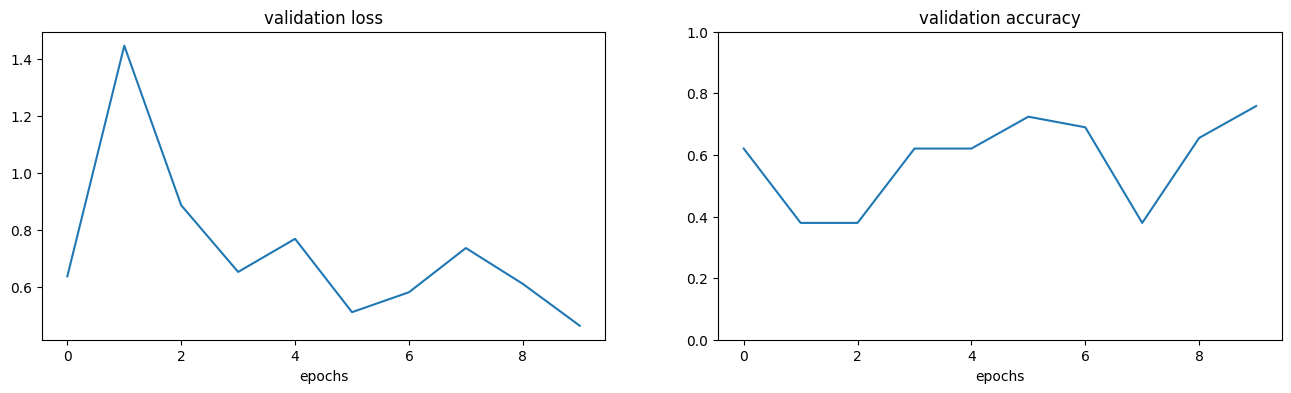

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Agora façamos uma validação final no conjunto de teste.

In [ ]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.404710590839386
Test accuracy: 0.8999999761581421


Note que dessa vez foi deu muito próximo de 90% o que é um bom sinal.

### Conclusão

  Por isso tudo, toma-se por concluído o projeto de realizar um transfer-learning de dois datasets, uma incluindo fotos de pandas e a outra de ursos polares, em uma rede neural já existente VGG16.

  O projeto serviu para mostrar mais uma ferramenta muito utilizada para quem trabalha com Machine Learning e com certeza será útil, nem que seja para tomar como inspiração para outros avanços.

## Referências

Esse Colab foi totalmente inspirado no colab: https://colab.research.google.com/github/kylemath/ml4a-guides/blob/master/notebooks/transfer-learning.ipynb